# GARBAGE STRATEGY AS OF NOW

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from binance.client import Client

In [4]:
api_key = "bT3JgDAiGkPkIDzVAGNXvRrLU5PePQz0kNz2Gtt8NFAatjfOOIiVoiMhjOk4t9RL"
secret_api_key = "IdrL486SQzb5QB5ruuakUZZdKwgTNGGEzM1VHQ6QPDSpZawrGCemjV1LNfOYCjWj"
client = Client(api_key=api_key, api_secret=secret_api_key, tld="com")

In [15]:
class RSI_backtester():
    
    def __init__(self, client, symbol, rsi_upper, rsi_lower, rsi_MA, train_start=None,
                 train_end=None, test_start=None, test_end=None, interval="1h"):
        
        self.symbol = symbol
        self.interval = interval
        self.rsi_upper = rsi_upper
        self.rsi_lower = rsi_lower
        self.rsi_MA = rsi_MA
        self.train_start = train_start
        self.train_end = train_end
        self.test_start = test_start
        self.test_end = test_end
        self.results = None
        self.get_data()
    def get_data(self):
        import os.path
        if os.path.isfile("{}_{}.csv".format(self.symbol, self.interval)):
            raw = pd.read_csv("{}_{}.csv".format(self.symbol, self.interval), parse_dates=[0])
            raw.set_index("date", inplace=True)
        else:
            timestamp = client._get_earliest_valid_timestamp(symbol=self.symbol, interval=self.interval)
            timestamp = str(pd.to_datetime(timestamp, unit="ms"))
            raw = client.get_historical_klines(symbol=self.symbol, start_str=timestamp, interval=self.interval)
            raw = pd.DataFrame(raw)
            raw.drop(list(range(6,12,1)), axis=1, inplace=True)
            column_names = ["date","open", "high","low","close","volume"]
            raw.columns = column_names
            raw["date"] = pd.to_datetime(raw["date"], unit="ms")
            raw.set_index("date", inplace=True)
            for col in raw.columns:
                raw[col] = pd.to_numeric(raw[col])
            raw.to_csv("{}_{}.csv".format(self.symbol, self.interval))
        self.train_data = raw.loc[self.train_start:self.train_end].copy()
        self.test_data = raw.loc[self.test_start:self.test_end]
    def ema_strategy(self, test=False):
        if not test:
            self.data = self.train_data.copy()
        else:
            self.data = self.test_data.copy()
        self.data["returns"] = np.log(self.data.close.pct_change() + 1)
        self.data["creturns"] = self.data.returns.cumsum().apply(np.exp)
        self.data["U"] = np.where(self.data.close.diff() > 0, self.data.close.diff(), 0)
        self.data["D"] = np.where(self.data.close.diff() < 0, -self.data.close.diff(), 0)
        self.data["MA_U"] = self.data.U.rolling(self.rsi_MA).mean()
        self.data["MA_D"] = self.data.D.rolling(self.rsi_MA).mean()
        self.data["RSI"] = self.data.MA_U / (self.data.MA_U + self.data.MA_D) * 100
        self.data.dropna(inplace=True)
        self.data["position"] = np.where(self.data["RSI"] > self.rsi_upper, -1, 0)
        self.data["position"] = np.where(self.data["RSI"] < self.rsi_lower, 1, self.data.position)
        self.data["strategy"] = self.data.position.shift() * self.data.returns
        self.data["trades"] = self.data.position.diff().fillna(0).abs()
        tc = 0.0012
        self.data["strategy_wtc"] = self.data.strategy - self.data["trades"] * tc
        self.data["cstrategy_wtc"] = self.data.strategy_wtc.cumsum().apply(np.exp)
    def plot_results(self):
        self.data[["creturns", "cstrategy_wtc"]].plot(figsize=(15,8), fontsize=13)
        plt.legend(fontsize=13)
    def result_df(self):
        return self.data
    def update_and_run(self, sma_r, test=False):
        self.EMA = sma_r[0]
        self.SMA = sma_r[1]
        self.ema_strategy(test=test)
        sharpe = (self.data.strategy_wtc.mean() * 365.25) / (self.data.strategy_wtc.std() * np.sqrt(365.25))
        return -sharpe
    def optimize_parameters(self, ema_range , sma_range):
        opt = brute(self.update_and_run, (ema_range, sma_range), finish=None)
        return opt

In [22]:
tester = RSI_backtester(client, "ETHUSDT", interval="1h", rsi_upper=70, rsi_lower=30, rsi_MA=30,
                       train_end= "2022-01-01", test_start="2022-01-01")

In [23]:
tester.ema_strategy()

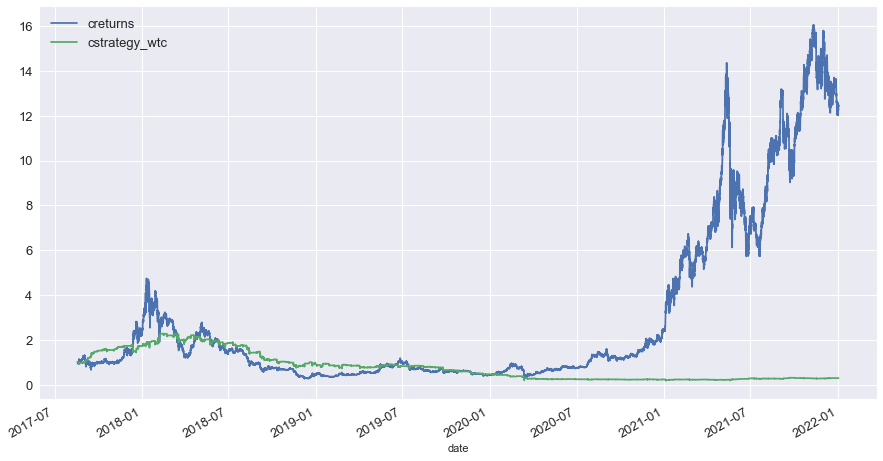

In [24]:
tester.plot_results()

## Strategy:
* Buy when recent yesterdays rsi value is above 70today's rsi value is below 70, close position when rsi is below 45
* Sell when recent yesterdays rsi value is below 30 today's rsi value is above 30, close position when rsi is above 55

In [132]:
rsi_MA = 40
rsi_upper = 70
rsi_lower = 30

In [133]:
        data = pd.read_csv("ETHUSDT_1h.csv")
        data["returns"] = np.log(data.close.pct_change() + 1)
        data["creturns"] = data.returns.cumsum().apply(np.exp)
        data["U"] = np.where(data.close.diff() > 0, data.close.diff(), 0)
        data["D"] = np.where(data.close.diff() < 0, -data.close.diff(), 0)
        data["MA_U"] = data.U.rolling(rsi_MA).mean()
        data["MA_D"] = data.D.rolling(rsi_MA).mean()
        data["RSI"] = data.MA_U / (data.MA_U + data.MA_D) * 100
        data.dropna(inplace=True)

In [134]:
data

,date,open,high,low,close,volume,returns,creturns,U,D,MA_U,MA_D,RSI
39,2017-08-18 19:00:00,289.75,295.60,287.37,293.83,445.23397,0.013983,0.974205,4.08,0.00,0.91025,1.10475,45.173697
40,2017-08-18 20:00:00,295.46,295.46,288.25,291.87,748.21537,-0.006693,0.967707,0.00,1.96,0.91025,1.15375,44.101260
41,2017-08-18 21:00:00,291.87,291.87,283.94,286.30,602.03512,-0.019268,0.949239,0.00,5.57,0.87300,1.29300,40.304709
42,2017-08-18 22:00:00,288.01,294.19,284.02,293.74,477.84453,0.025655,0.973907,7.44,0.00,1.05900,1.28250,45.227418
43,2017-08-18 23:00:00,293.74,294.18,289.97,293.96,93.91956,0.000749,0.974636,0.22,0.00,0.93250,1.28250,42.099323
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44348,2022-09-13 07:00:00,1706.63,1722.06,1699.32,1715.99,31712.41900,0.005470,5.689433,9.36,0.00,4.53075,5.85100,43.641486
44349,2022-09-13 08:00:00,1715.99,1718.28,1708.30,1714.93,13912.49230,-0.000618,5.685919,0.00,1.06,4.46725,5.87750,43.183741
44350,2022-09-13 09:00:00,1714.94,1725.99,1714.07,1722.06,25828.93510,0.004149,5.709559,7.13,0.00,4.64350,5.87750,44.135538
44351,2022-09-13 10:00:00,1722.06,1740.88,1718.86,1731.78,30380.58890,0.005629,5.741786,9.72,0.00,4.88650,5.60650,46.569141


In [135]:
data["long_entry"] = np.where((data.RSI.shift(1).dropna() > 75) & (data.RSI < 75), 1, 0)
data["long_exit"] = np.where((data.RSI.shift(1).dropna() > 45) & (data.RSI < 45), 1, 0)
data["short_entry"] = np.where((data.RSI.shift(1).dropna() < 25) & (data.RSI > 25), 1, 0)
data["short_exit"] = np.where((data.RSI.shift(1).dropna() < 55) & (data.RSI > 55), 1, 0)

In [136]:
trades = data[["long_entry", "long_exit", "short_entry", "short_exit"]].copy()

In [137]:
long_entry_dates = []
long_exit_dates = []
short_entry_dates = []
short_exit_dates = []
long_inpos=False
short_inpos=False
for i in range(len(trades)):
    if trades.iloc[i].long_entry==1:
        if long_inpos==False and short_inpos==False:
            long_entry_dates.append(trades.index[i])
            long_inpos=True
    if trades.iloc[i].long_exit==1:
        if long_inpos==True:
            long_exit_dates.append(trades.index[i])
            long_inpos=False
    if trades.iloc[i].short_entry==1:
        if long_inpos==False and short_inpos==False:
            short_entry_dates.append(trades.index[i])
            short_inpos=True
    if trades.iloc[i].short_exit==1:
        if short_inpos==True:
            short_exit_dates.append(trades.index[i])
            short_inpos=False
if len(long_entry_dates) > len(long_exit_dates):
    long_entry_dates.pop(-1)
if len(short_entry_dates) > len(short_exit_dates):
    short_entry_dates.pop(-1)
data["long_position"] = 0
data["short_position"] = 0
long_inposition_intervals = []
short_inposition_intervals = []
for i in range(len(long_entry_dates)):
    long_inposition_intervals.append([long_entry_dates[i], long_exit_dates[i]])
for long_inposition_interval in long_inposition_intervals:
    data.loc[long_inposition_interval[0]:long_inposition_interval[1], "long_position"] = 1
for i in range(len(short_entry_dates)):
    short_inposition_intervals.append([short_entry_dates[i], short_exit_dates[i]])
for short_inposition_interval in short_inposition_intervals:
    data.loc[short_inposition_interval[0]:short_inposition_interval[1], "short_position"] = 1

In [138]:
data["strategy"] = (data.long_position * data.returns) + (-data.short_position * data.returns)

<AxesSubplot:>

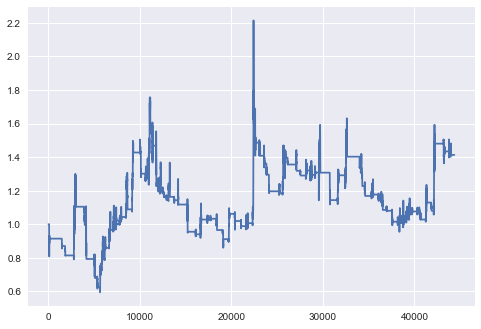

In [143]:
np.exp(data["strategy"].cumsum()).plot()

In [140]:
(data.strategy.mean() * 24 * 365.25) / (data.strategy.std() * np.sqrt(24 * 365.25))

0.12879632160843238

In [141]:
np.exp(data.returns.sum())

5.9966522864538145

# RSI is garbage